In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,expr,variance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
spark = SparkSession.builder \
    .appName("EDA") \
    .getOrCreate()

In [ ]:
file_path = "/content/customer_data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
df.printSchema() # in ra cấu trúc của DataFrame

root
 |-- ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Ever_Married: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Graduated: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Work_Experience: integer (nullable = true)
 |-- Spending_Score: string (nullable = true)
 |-- Family_Size: integer (nullable = true)



In [ ]:
df.show() # Hiển thị một số mẫu của DataFrame

+------+------+------------+---+---------+----------+---------------+--------------+-----------+
|    ID|Gender|Ever_Married|Age|Graduated|Profession|Work_Experience|Spending_Score|Family_Size|
+------+------+------------+---+---------+----------+---------------+--------------+-----------+
|458989|Female|         Yes| 36|      Yes|  Engineer|              0|           Low|          1|
|458994|  Male|         Yes| 37|      Yes|Healthcare|              8|       Average|          4|
|458996|Female|         Yes| 69|       No|      NULL|              0|           Low|          1|
|459000|  Male|         Yes| 59|       No| Executive|             11|          High|          2|
|459001|Female|          No| 19|       No| Marketing|           NULL|           Low|          4|
|459003|  Male|         Yes| 47|      Yes|    Doctor|              0|          High|          5|
|459005|  Male|         Yes| 61|      Yes|    Doctor|              5|           Low|          3|
|459008|Female|         Yes| 4

In [ ]:
print("Số dòng của dữ liệu: ",df.count())
print("Số cột của dữ liệu: ",len(df.columns))

Số dòng của dữ liệu:  10695
Số cột của dữ liệu:  9


Nhận xét: Cả bộ dữ liệu có 10695 mẫu và có 9 cột.

In [ ]:
# Thống kê số lượng giá trị Null của từng cột
null_counts = [(col_name, df.where(col(col_name).isNull()).count()) for col_name in df.columns]
# Thực hiện in ra màn hình số lượng giá trị Null của từng cột
for col_name, count in null_counts:
    print(f"Column '{col_name}' has {count} null values.")

Column 'ID' has 0 null values.
Column 'Gender' has 0 null values.
Column 'Ever_Married' has 190 null values.
Column 'Age' has 0 null values.
Column 'Graduated' has 102 null values.
Column 'Profession' has 162 null values.
Column 'Work_Experience' has 1098 null values.
Column 'Spending_Score' has 0 null values.
Column 'Family_Size' has 448 null values.


In [ ]:
# Phân chia các cột của bộ dữ liệu thành 2 nhóm: 1 nhóm là biến phân loại và 1 nhóm là biến số
category_columns = [col_name for col_name, data_type in df.dtypes if data_type == "string"] # Đây là các cột chứa biến phân loại
numeric_columns = [col_name for col_name, data_type in df.dtypes if data_type != "string"] # Đây là các cột chứa biến số

# Summary cho các cột category
# In ra các cột thuộc 2 nhóm trên
print("Category columns: ",category_columns)
print("Numeric_columns: ",numeric_columns)

Category columns:  ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']
Numeric_columns:  ['ID', 'Age', 'Work_Experience', 'Family_Size']


In [ ]:
# Chọn các cột trong nhóm biến số để tính các thống kê tóm tắt như trung bình, độ lệch chuẩn, min, max, và số lượng không null.
# Sau đó hiển thị ra màn hình bản tóm tắt
df.select(numeric_columns).summary().show()

+-------+-----------------+-----------------+-----------------+------------------+
|summary|               ID|              Age|  Work_Experience|       Family_Size|
+-------+-----------------+-----------------+-----------------+------------------+
|  count|            10695|            10695|             9597|             10247|
|   mean|463468.0886395512|43.51182795698925|2.619777013650099|2.8440519176344297|
| stddev|2600.966410717563|16.77415816252163|3.390789548816187|1.5364271953729591|
|    min|           458982|               18|                0|                 1|
|    25%|           461220|               30|                0|                 2|
|    50%|           463450|               41|                1|                 2|
|    75%|           465733|               53|                4|                 4|
|    max|           467974|               89|               14|                 9|
+-------+-----------------+-----------------+-----------------+------------------+



In [ ]:
def median_formula(data_frame, column_name):
    # Tính giá trị trung vị (median) của cột trong DataFrame sử dụng hàm percentile_approx
    median_result = data_frame.agg(expr(f"percentile_approx({column_name}, 0.5, 1000000)").alias("Median"))
    # Thu thập kết quả và trả về giá trị trung vị
    return median_result.collect()[0]["Median"]

# Lặp qua từng cột số để tính giá trị trung vị
for column in numeric_columns:
    # Gọi hàm median_formula để tính giá trị trung vị của cột
    median_result = median_formula(df, column)
    # In ra giá trị trung vị của cột
    print(f"Median value of {column}:", median_result)


Median value of ID: 463451
Median value of Age: 41
Median value of Work_Experience: 1
Median value of Family_Size: 3


In [ ]:
def variance_formula(data_frame, column_name):
    # Tính giá trị phương sai (variance) của cột trong DataFrame
    variance_result = data_frame.select(variance(column_name))
    # Thu thập kết quả và trả về giá trị phương sai
    return variance_result.collect()[0][0]

# Lặp qua từng cột số để tính giá trị phương sai
for column in numeric_columns:
    # Gọi hàm variance_formula để tính giá trị phương sai của cột
    variance_result = variance_formula(df, column)
    # In ra giá trị phương sai của cột
    print(f"Variance value of {column}:", variance_result)


Variance value of ID: 6765026.269681004
Variance value of Age: 281.372382061291
Variance value of Work_Experience: 11.497453764361081
Variance value of Family_Size: 2.360608526681617


In [ ]:
def mode_formula(data_frame, column_name):
    # Nhóm các giá trị trong cột và đếm số lần xuất hiện của mỗi giá trị
    count_df = data_frame.groupBy(column_name).count()
    # Sắp xếp các giá trị theo số lần xuất hiện giảm dần và chọn giá trị xuất hiện nhiều nhất
    mode_result = count_df.orderBy(col("count").desc()).select(column_name).first()[0]
    # Trả về giá trị mode (giá trị xuất hiện nhiều nhất)
    return mode_result

# Lặp qua từng cột phân loại để tính giá trị mode
for column in category_columns:
    # Gọi hàm mode_formula để tính giá trị mode của cột
    mode_result = mode_formula(df, column)
    # In ra giá trị mode của cột
    print(f"Mode value of {column}:", mode_result)


Mode value of Gender: Male
Mode value of Ever_Married: Yes
Mode value of Graduated: Yes
Mode value of Profession: Artist
Mode value of Spending_Score: Low


In [ ]:
def rarest_value(data_frame, column_name):
    # Lọc bỏ các giá trị Null trong cột
    filtered_df = data_frame.filter(col(column_name).isNotNull())
    # Nhóm các giá trị trong cột và đếm số lần xuất hiện của mỗi giá trị
    count_df = filtered_df.groupBy(column_name).count()
    # Sắp xếp các giá trị theo số lần xuất hiện tăng dần và chọn giá trị xuất hiện ít nhất
    rarest_value = count_df.orderBy(col("count")).select(column_name).first()[0]
    # Trả về giá trị hiếm nhất (rarest value)
    return rarest_value

# Lặp qua từng cột phân loại để tính giá trị hiếm nhất
for column in category_columns:
    # Gọi hàm rarest_value để tính giá trị hiếm nhất của cột
    rarest_result = rarest_value(df, column)
    # In ra giá trị hiếm nhất của cột
    print(f"Rarest value of {column}:", rarest_result)


Rarest value of Gender: Female
Rarest value of Ever_Married: No
Rarest value of Graduated: No
Rarest value of Profession: Homemaker
Rarest value of Spending_Score: High


In [ ]:
def plot_histogram(data_frame, column_name):
    # Lọc ra các dòng không chứa giá trị null trong cột cụ thể
    filtered_data = data_frame.filter(data_frame[column_name].isNotNull())

    # Lấy dữ liệu của cột cần vẽ histogram
    column_data = filtered_data.select(column_name).rdd.flatMap(lambda x: x).collect()

    # Vẽ histogram
    plt.hist(column_data, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    plt.grid(True)

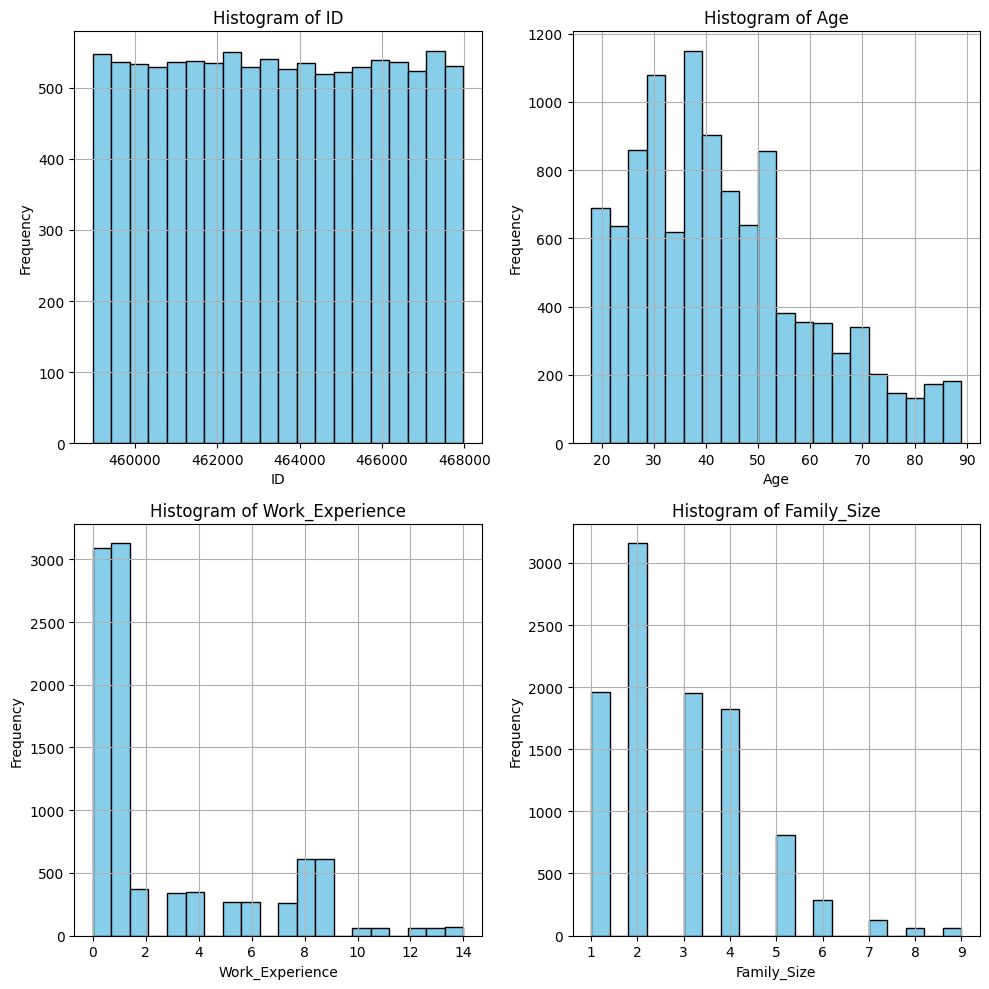

In [ ]:
plt.figure(figsize=(10, 10))  # Khởi tạo một figure có kích thước 20x20 inches

for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i+1)  # Tạo subplot trong lưới 2x2, đặt subplot thứ i+1
    plot_histogram(df, col)  # Vẽ histogram cho cột numeric thứ i

plt.tight_layout()  # Tự động điều chỉnh layout
plt.show()  # Hiển thị figure với các subplot

In [ ]:
def plot_barplot(data_frame, column_name):
    # Lọc ra các dòng không chứa giá trị null trong cột cụ thể
    filtered_data = data_frame.filter(data_frame[column_name].isNotNull())
    # Nhóm dữ liệu theo giá trị của cột phân loại và đếm số lần xuất hiện của mỗi giá trị
    category_counts = filtered_data.groupBy(column_name).count().orderBy(column_name).collect()

    # Lấy danh sách các giá trị của cột và số lần xuất hiện tương ứng
    categories = [row[column_name] for row in category_counts]
    counts = [row["count"] for row in category_counts]

    # Vẽ biểu đồ barplot
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Barplot of {column_name}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')

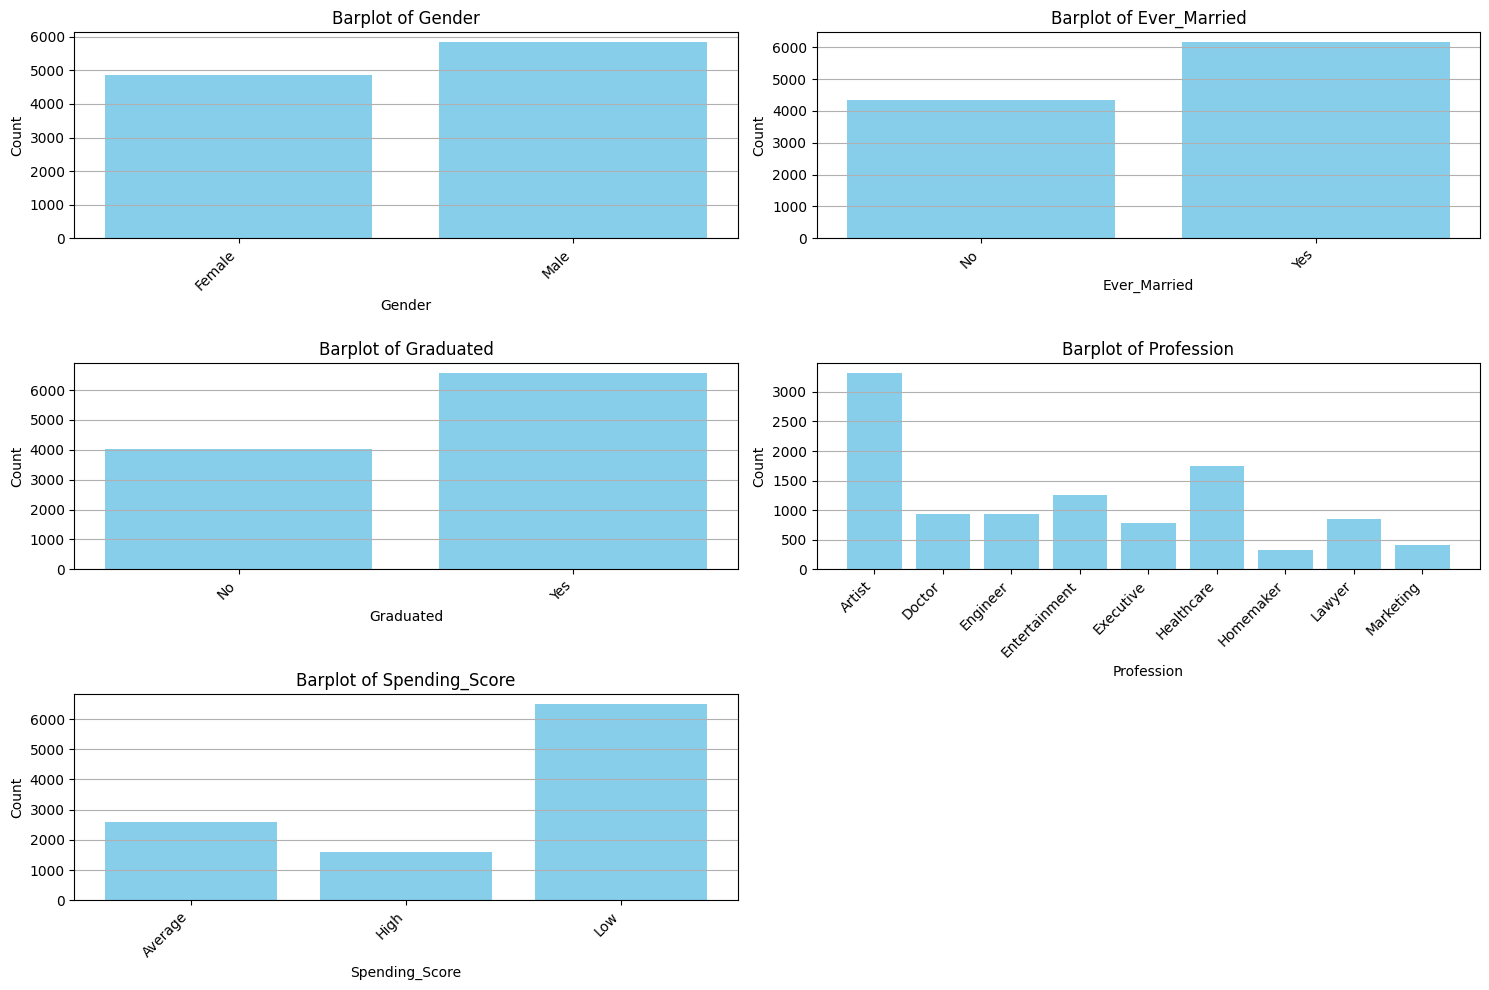

In [ ]:
plt.figure(figsize=(15, 10))  # Khởi tạo một figure có kích thước 15x10 inches

for i, col in enumerate(categorical_columns):
    plt.subplot(3, 2, i+1)  # Tạo subplot trong lưới 3x2, đặt subplot thứ i+1
    plot_barplot(df, col)  # Vẽ biểu đồ barplot cho cột phân loại thứ i

plt.tight_layout()  # Tự động điều chỉnh layout
plt.show()  # Hiển thị figure với các subplot

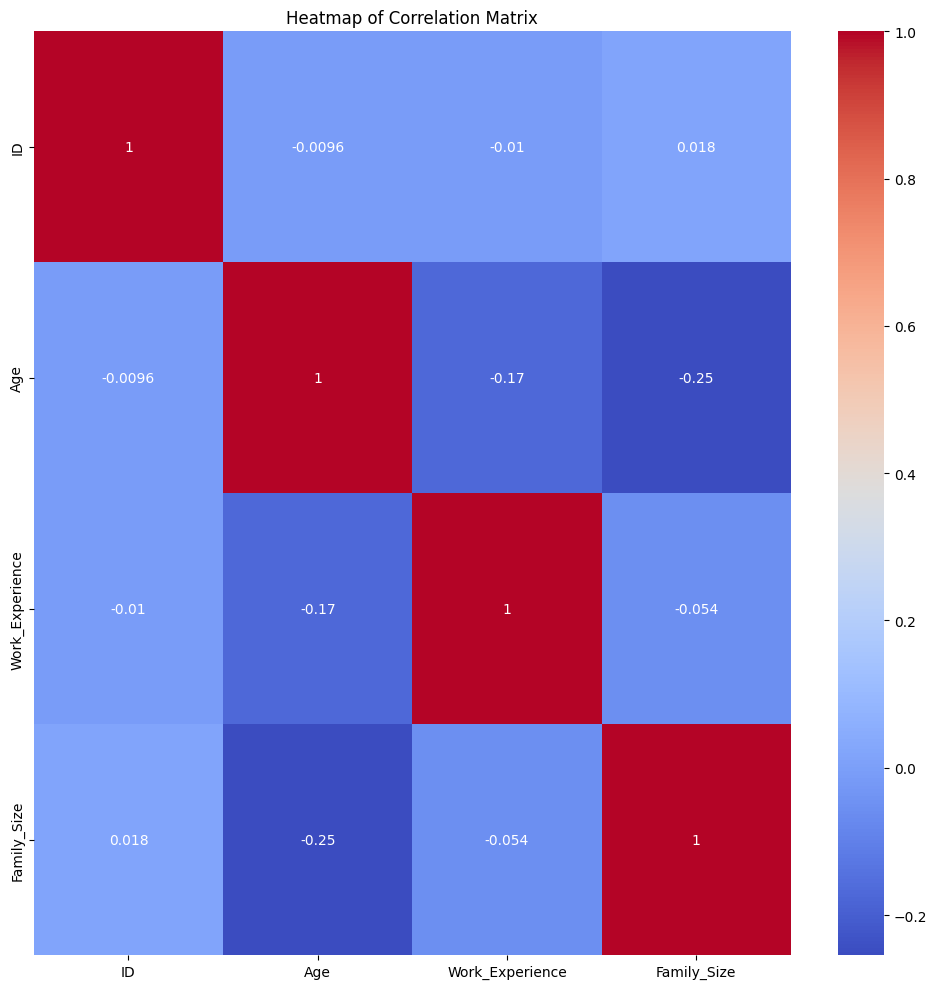

In [ ]:
# Tính toán ma trận hệ số tương quan giữa các cột
correlation_matrix = []

for col1 in numeric_columns:
    row = []
    for col2 in numeric_columns:
        corr_value = df.stat.corr(col1, col2)
        row.append(corr_value)
    correlation_matrix.append(row)

# Chuyển đổi ma trận hệ số tương quan thành mảng Numpy
correlation_matrix_np = np.array(correlation_matrix)

plt.figure(figsize=(10,10))
# Vẽ biểu đồ nhiệt
sns.heatmap(correlation_matrix_np, annot=True, cmap="coolwarm", xticklabels=numeric_columns, yticklabels=numeric_columns)
plt.title("Heatmap of Correlation Matrix")

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()